# Génération d'un graphe non orienté aléatoire avec matrice d'adjacence pondérée
Ce notebook a pour objectif de générer un graphe non orienté, connexe et complet, avec des pondérations aléatoires représentant les coûts des routes.
Il permet également de simuler des routes en travaux (inutilisables) et de visualiser le graphe.

Nous utilisons :

- **NetworkX** pour la manipulation des graphes,

- **NumPy** pour la gestion des matrices,

- **Matplotlib** pour l'affichage visuel.

In [ ]:
# Importation des bibliothèques nécessaires
import networkx as nx        # Manipulation de graphes
import numpy as np           # Création et gestion de matrices
import random                # Génération aléatoire de données
import matplotlib.pyplot as plt  # Affichage graphique
import pandas as pd #export csv
import os #export csv

In [9]:
def generer_matrice_connexe_et_complete(n_sommets, cout_max=10, taux_travaux=0.2):
    # Création d'une matrice carrée de zéros, taille n_sommets x n_sommets
    matrice = np.zeros((n_sommets, n_sommets), dtype=int)

    # Étape 1 : Génération d’un arbre couvrant aléatoire pour garantir la connexité
    sommets = list(range(n_sommets))
    random.shuffle(sommets)  # Mélange aléatoire des sommets

    # Création d’un arbre couvrant : on connecte chaque sommet au suivant
    for i in range(n_sommets - 1):
        a, b = sommets[i], sommets[i + 1]
        cout = random.randint(1, cout_max)  # Coût aléatoire entre les sommets
        matrice[a][b] = cout
        matrice[b][a] = cout  # Symétrie pour graphe non orienté

    # Étape 2 : Complétion de la matrice pour obtenir un graphe complet
    for i in range(n_sommets):
        for j in range(i + 1, n_sommets):
            if matrice[i][j] == 0:
                if random.random() < taux_travaux:
                    val = -1  # Route en travaux : inutilisable
                else:
                    val = random.randint(1, cout_max)  # Route praticable
                matrice[i][j] = val
                matrice[j][i] = val  # Symétrie

    # Étape 3 : Initialisation des diagonales à 0 (coût nul vers soi-même)
    np.fill_diagonal(matrice, 0)

    # Étape 4 : Vérification que le graphe est toujours connexe via NetworkX
    G = nx.Graph()
    for i in range(n_sommets):
        for j in range(i + 1, n_sommets):
            if matrice[i][j] > 0:  # Seules les routes praticables sont ajoutées
                G.add_edge(i, j)

    if not nx.is_connected(G):
        # Reconnexion manuelle si le graphe a été fragmenté par des travaux
        composants = list(nx.connected_components(G))
        for k in range(len(composants) - 1):
            u = random.choice(list(composants[k]))
            v = random.choice(list(composants[k + 1]))
            cout = random.randint(1, cout_max)
            matrice[u][v] = cout
            matrice[v][u] = cout

    return matrice


Cette fonction `generer_matrice_connexe_et_complete` crée une matrice représentant un graphe :
- Connexe grâce à la génération d’un arbre couvrant initial.
- Complet, car toutes les paires de sommets sont connectées ensuite.
- Les routes sont soit :
  - **en travaux** (valeur `-1`)
  - **praticables** (valeurs > 0, avec un coût aléatoire)
Contrairement à la version précédente, **aucune route n'est absente** (valeur `0`).


In [10]:
def afficher_matrice_liste(matrice):
    # Affichage lisible de la matrice sous forme de liste de listes
    print("[")
    for ligne in matrice:
        print("    " + str(list(map(int, ligne))) + ",")
    print("]")


La fonction `afficher_matrice_liste` permet d'afficher la matrice sous forme de liste de listes, ce qui rend la lecture plus facile et plus claire.


In [11]:
def afficher_graphe(matrice):
    G = nx.Graph()
    n_sommets = len(matrice)

    # Ajout des arêtes selon la matrice d’adjacence
    for i in range(n_sommets):
        for j in range(i + 1, n_sommets):
            poids = matrice[i][j]
            if poids != 0:  # On ne trace pas les diagonales
                # Ajout avec une propriété "travaux" pour la couleur
                G.add_edge(i + 1, j + 1, weight=poids, travaux=(poids == -1))

    # Positionnement automatique des sommets
    pos = nx.spring_layout(G, seed=42)

    # Définition des couleurs : rouge pour les travaux, gris sinon
    edge_colors = ['red' if G[u][v]['travaux'] else 'gray' for u, v in G.edges()]
    
    # Étiquettes : afficher les poids sauf pour les routes en travaux
    edge_labels = {
        (u, v): ('' if G[u][v]['travaux'] else G[u][v]['weight']) for u, v in G.edges()
    }

    # Affichage du graphe avec Matplotlib
    plt.figure(figsize=(10, 8))
    nx.draw(
        G, pos, with_labels=True, node_color='skyblue', node_size=600,
        edge_color=edge_colors, width=2, font_weight='bold'
    )
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='black')
    plt.title("Graphe Complet – Routes praticables (gris), en travaux (rouge)")
    plt.show()


Cette fonction `afficher_graphe` construit un graphe à partir de la matrice :
- Les arêtes **praticables** sont affichées en **gris** avec leur coût.
- Les arêtes **en travaux** sont affichées en **rouge** sans étiquette de poids.
Elle utilise `networkx` et `matplotlib` pour représenter visuellement la structure du graphe.


In [ ]:
# Fonction d'exportation de la matrice vers un fichier CSV sans les noms des villes
def exporter_csv(matrice, nom_fichier="matrice_routes.csv"):
    chemin_fichier = os.path.join("data", nom_fichier)
    # Création du DataFrame 
    df = pd.DataFrame(matrice)
    # Exportation du DataFrame vers un fichier CSV avec un séparateur de type point-virgule
    df.to_csv(chemin_fichier, header=False, index=False, sep=";")
    print(f"Matrice exportée avec succès vers « {nom_fichier} »")

[
    [0, 143, 9, -1, 123, 166],
    [143, 0, -1, 182, -1, 163],
    [9, -1, 0, 182, 82, 3],
    [-1, 182, 182, 0, 115, 41],
    [123, -1, 82, 115, 0, 47],
    [166, 163, 3, 41, 47, 0],
]


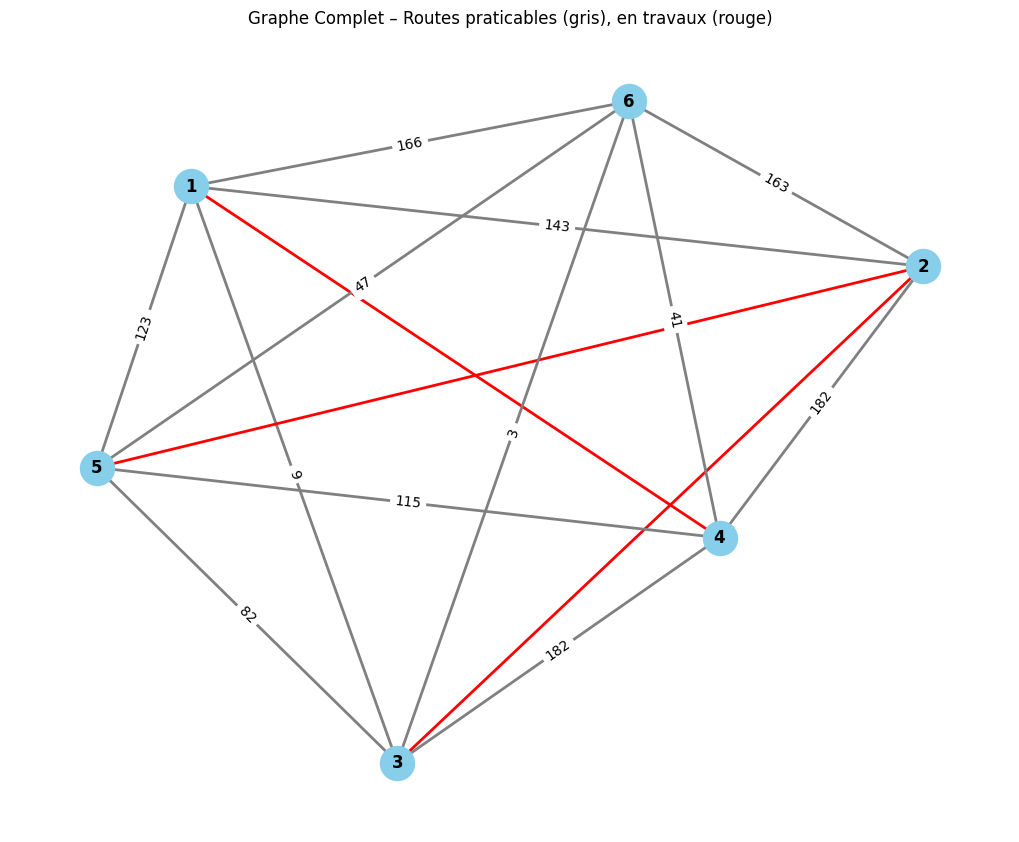

Matrice exportée avec succès vers « matrice_routes.csv »


In [21]:
# Génère un graphe avec 6 villes, coûts max de 200km, et 20% de routes en travaux
matrice = generer_matrice_connexe_et_complete(n_sommets=6, cout_max=200, taux_travaux=0.2)

# Affiche la matrice au format liste
afficher_matrice_liste(matrice)

# Visualise le graphe
afficher_graphe(matrice)

# Export de la matrice 
exporter_csv(matrice)

Cette cellule utilise les fonctions précédentes pour :
- Générer une matrice de graphe avec 8 sommets, sans routes absentes.
- Afficher la matrice correspondante.
- Visualiser le graphe avec les routes praticables et celles en travaux.
